In [3]:
#%% Análisis de las primeras mediciones del espectro del rubidio,
#Sin descomponer en polarización circ izquierda ni nada.

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
import os

In [4]:
def cargar_datos(n, i, ruta):
    #n número de datos tomados +1
    # i número de medición -1 (empezando a contar desde 1)

    columnas = [f'{j}' for j in range(1, n)]

    # Rutas a archivos
    señales_Ch1 = os.path.join(ruta, 'Mediciones_CH1.csv')
    señales_Ch2 = os.path.join(ruta, 'Mediciones_CH2.csv')
    tiempos_Ch1 = os.path.join(ruta, 'Tiempos_CH1.csv')
    tiempos_Ch2 = os.path.join(ruta, 'Tiempos_CH2.csv')
    unidades_escalas = os.path.join(ruta, 'Unidades y escala.csv')

    # Lectura de archivos
    data_señales_Ch1 = pd.read_csv(señales_Ch1, skiprows=3, delimiter=',', header=None, names=columnas)
    data_señales_Ch2 = pd.read_csv(señales_Ch2, skiprows=3, delimiter=',', header=None, names=columnas)
    data_tiempos_Ch1 = pd.read_csv(tiempos_Ch1, skiprows=3, delimiter=',', header=None, names=columnas)
    data_tiempos_Ch2 = pd.read_csv(tiempos_Ch2, skiprows=3, delimiter=',', header=None, names=columnas)
    data_unidades_escalas = pd.read_csv(unidades_escalas, delimiter=',', header=None, names=columnas)

    # Selección de columna
    col_name = str(i + 1)

    # Extraer variables

    globals()['tiempos1'] = data_tiempos_Ch1[col_name].values
    globals()['voltajes1'] = data_señales_Ch1[col_name].values

    globals()['tiempos2'] = data_tiempos_Ch2[col_name].values
    globals()['voltajes2'] = data_señales_Ch2[col_name].values

    escala_Ch1 = float(data_unidades_escalas[col_name].iloc[4])
    escala_Ch2 = float(data_unidades_escalas[col_name].iloc[8])

    globals()['error_Ch1'] = escala_Ch1 * 10 / 256
    globals()['error_Ch2'] = escala_Ch2 * 10 / 256



def lineal(x, m, b):
  y =  m * x + b
  return y








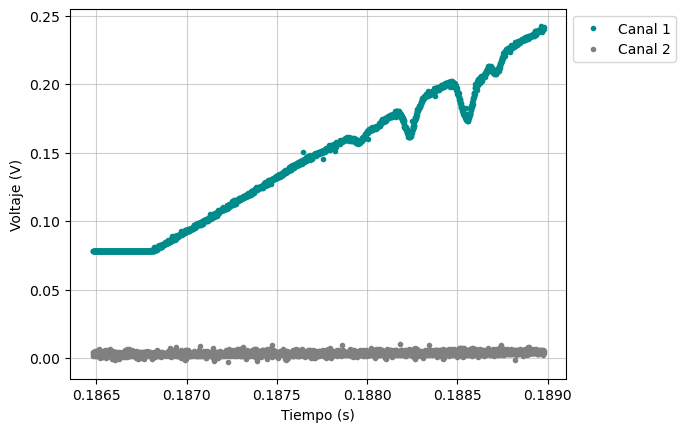

In [5]:
cargar_datos(n=2, i=0, ruta='/Users/Mauri/Desktop/Labo 5/Espectroscopía láser/Med1')

# Graficamos ambos canales.
plt.plot(tiempos1, voltajes1,'.', color = 'darkcyan', label= 'Canal 1')
plt.plot(tiempos2, voltajes2, '.', color ='gray', label= 'Canal 2')
plt.xlabel('Tiempo (s)')
plt.ylabel('Voltaje (V)')
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
#plt.xlim(-0.0015,-00.0016)
plt.grid(alpha = 0.6)
plt.show()

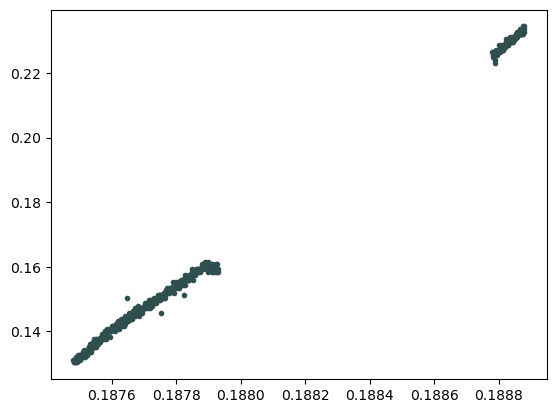

   Los parametros óptimos son  Los errores de los parámetros son
0                   72.723805                           0.074077
1                  -13.503222                           0.013920


In [6]:

#Ahora hay que restarle los puntos de una recta con pendiente igual a la obtenida en la curva pitencia vs corriente
#(asumiendo que más voltaje = más potencia)

# Como las mediciones de potencia vs corriente salieron mal, ajusto por la recta en la región de antes
# de las líneas espectrales para restarle esa lineal a las mediciones

A = 1000
B = 1450

C = 2300
D = 2400

plt.plot(tiempos2[A:B], voltajes1[A:B], ".", color = 'darkslategray')
plt.plot(tiempos2[C:D], voltajes1[C:D], ".", color = 'darkslategray')

plt.show()

#para que esté bien plana la señal, uso un intervalo antes del espectro, y después del espectro,
#y realizo el ajuste lineal con estos dos intervalos
voltajes_intervalos = np.concatenate([voltajes1[A:B], voltajes1[C:D]])
tiempos_intervalos = np.concatenate([tiempos2[A:B], tiempos2[C:D]])

#Cuando se vea la recta, hago el ajuste:

param_iniciales = [0.01, 0]
popt_0, pcov_0 = curve_fit(lineal, tiempos_intervalos,voltajes_intervalos, p0=param_iniciales, sigma = error_Ch1, absolute_sigma=True)
incertidumbre_0 = np.sqrt(np.diag(pcov_0))

tabla = pd.DataFrame({
        'Los parametros óptimos son': popt_0,
        'Los errores de los parámetros son': incertidumbre_0,
        })

print(tabla)



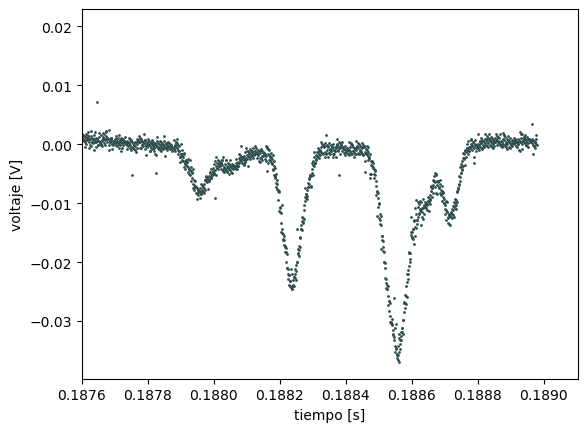

In [7]:
#Grafico el espectro sin la componente que hace crecer la intensidad del láser por
#el solo hecho de que tiene más corriente

x_fit_n =  np.linspace(np.min(tiempos2), np.max(tiempos2), len(tiempos2), endpoint = True)

plt.plot(tiempos2, voltajes1 - lineal(x_fit_n, *popt_0), ".", markersize=2, color = 'darkslategray')

plt.xlabel('tiempo [s]')
plt.ylabel('voltaje [V]')

plt.xlim(0.1876)
plt.show()


espectro = voltajes1 - lineal(x_fit_n, *popt_0)


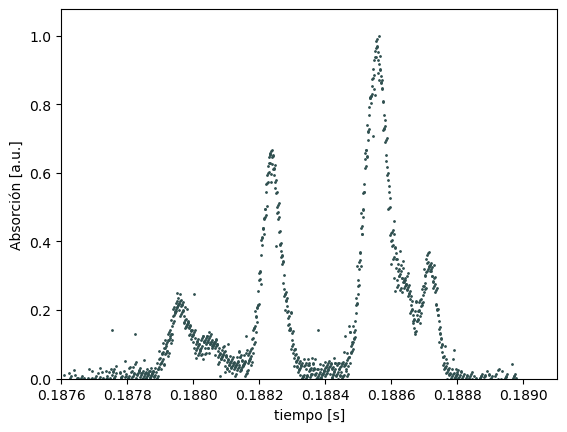

In [15]:
#inertimos, para graficar la Absorción en función del tiempo
#Y normalizamos para que el pico de mayor amplitud valga 1

espectro_inv = espectro * (-1)
espectro_norm = espectro_inv / np.max(espectro_inv)


plt.plot(tiempos2, espectro_norm, ".", markersize=2, color = 'darkslategray')

plt.xlabel('tiempo [s]')
plt.ylabel('Absorción [a.u.]')

plt.xlim(0.1876)
plt.ylim(0)
plt.show()



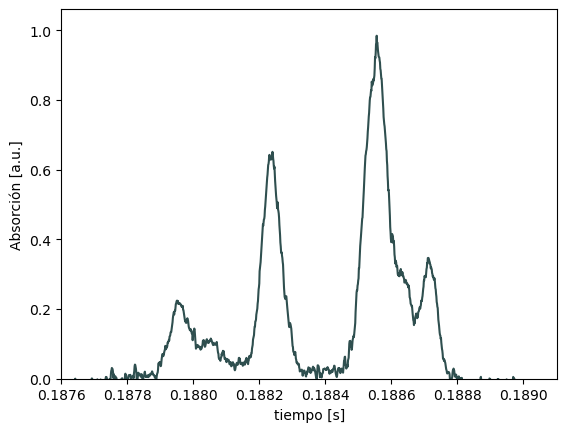

In [13]:
#pruebo de interpolar para suavizar la señal:

#(filtro 'Savitzky-Golay')
from scipy.signal import savgol_filter
señal_suavizada = savgol_filter(espectro_norm, window_length=11, polyorder=2)

plt.plot(tiempos2, señal_suavizada, "-", markersize=2, color = 'darkslategray')

plt.xlabel('tiempo [s]')
plt.ylabel('Absorción [a.u.]')

plt.xlim(0.1876)
plt.ylim(0)
plt.show()